# Importing dataset

In [1]:
!pip install opencv-python

In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import io
import pandas as pd
import cv2
import sklearn

In [3]:
#Import classification_tags
table = pd.read_csv("D:/Geoprocessamento/DataSetModelo/classification_tags.csv",index_col="index")

# Dataset Analysis
#### Separando os dados de acordo com a % de cobertura de nuvens

In [4]:
table.head(15)

scene  difficulty  \
index                                                                  
0      S2A_MSIL1C_20180101T010721_N0206_R045_T53HLD_2...           1   
1      S2A_MSIL1C_20180101T074231_N0206_R049_T37LDJ_2...           4   
2      S2A_MSIL1C_20180102T084341_N0206_R064_T36TVP_2...           4   
3      S2A_MSIL1C_20180107T111431_N0206_R137_T31VEE_2...           2   
4      S2A_MSIL1C_20180108T104421_N0206_R008_T31TEF_2...           1   
5      S2A_MSIL1C_20180113T234301_N0206_R087_T57JUL_2...           4   
6      S2A_MSIL1C_20180117T111401_N0206_R137_T30UWB_2...           3   
7      S2A_MSIL1C_20180123T000731_N0206_R073_T56LPR_2...           3   
8      S2A_MSIL1C_20180124T230901_N0206_R101_T58LGM_2...           1   
9      S2A_MSIL1C_20180125T071151_N0206_R106_T41VPF_2...           1   
10     S2A_MSIL1C_20180126T032011_N0206_R118_T49TGK_2...           4   
11     S2A_MSIL1C_20180127T231851_N0206_R001_T58LDK_2...           1   
12     S2A_MSIL1C_20180130T194641_N0206_R042_T09UVS_2...           2   
13     S2A_MSIL1C_20180130T232841_N0206_R044_T58KBF_2...           3   
14     S2A_MSIL1C_20180201T142241_N0206_R067_T14CNV_2...           1   

      annotator  shadows_marked  clear_percent  cloud_percent  shadow_percent  \
index                                                                           
0             A               1       0.000000     100.000000        0.000000   
1             B               1       2.857105      94.907629        2.235266   
2             B               1      75.115464      15.194967        9.689569   
3             B               1       0.000000      99.540539        0.459461   
4             B               1       0.000000     100.000000        0.000000   
5             B               1       0.413793      98.605244        0.980963   
6             B               1      74.534411      17.914013        7.551576   
7             A               1       0.000000      99.876398        0.123602   
8             B               1       0.000000     100.000000        0.000000   
9             A               1     100.000000       0.000000        0.000000   
10            B               0      76.777528      23.222472        0.000000   
11            A               1       0.000000     100.000000        0.000000   
12            B               0      51.554835      48.445165        0.000000   
13            B               1      59.765875      35.060470        5.173655   
14            B               1       0.000000     100.000000        0.000000   

           dataset  forest/jungle  snow/ice  ...  high  isolated  extended  \
index                                        ...                             
0             MAIN              0         0  ...     0         0         1   
1             MAIN              0         0  ...     1         0         1   
2             MAIN              0         0  ...     0         1         0   
3             MAIN              0         0  ...     0         0         1   
4             MAIN              0         0  ...     1         0         1   
5       VALIDATION              0         0  ...     1         0         1   
6             MAIN              1         0  ...     0         1         0   
7       VALIDATION              0         0  ...     1         0         1   
8             MAIN              0         0  ...     1         0         1   
9             MAIN              1         1  ...     0         0         0   
10     CALIBRATION              0         1  ...     1         1         0   
11            MAIN              0         0  ...     1         0         1   
12            MAIN              0         0  ...     1         1         0   
13            MAIN              0         0  ...     1         1         0   
14            MAIN              0         0  ...     1         0         1   

       cumulus  cumulonimbus  altocumulus/stratocumulus  cirrus  haze/fog  \
index                                       

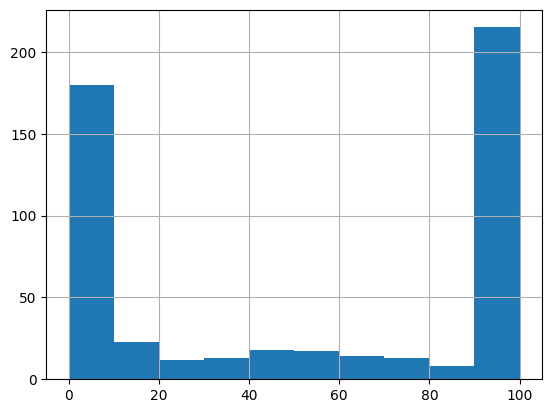

In [5]:
table['cloud_percent'].hist()
plt.show()

In [6]:
table['cloud_percent_cat'] = pd.cut(table['cloud_percent'], 
                               bins=[-np.inf,25.,50.,75.,np.inf], 
                                     labels = [1,2,3,4]
                                   )

In [7]:
'''
table['cloud_percent_cat'] = pd.cut(table['cloud_percent'], 
                               bins=[-np.inf,25.,50.,75.,np.inf], 
                                     labels = ['0-25%','25-50%','50-75%','75-100%']
                                   )
'''

"\ntable['cloud_percent_cat'] = pd.cut(table['cloud_percent'], \n                               bins=[-np.inf,25.,50.,75.,np.inf], \n                                     labels = ['0-25%','25-50%','50-75%','75-100%']\n                                   )\n"

In [8]:
table_sort = table.sort_values(by='cloud_percent_cat', ascending=True)

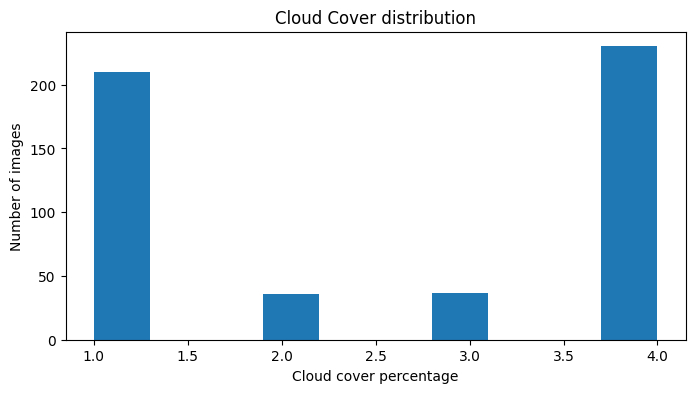

In [9]:
plt.figure(figsize=(8, 4))
plt.title('Cloud Cover distribution')
table_sort['cloud_percent_cat'].hist()
plt.xlabel('Cloud cover percentage')
plt.ylabel('Number of images')
plt.grid(False)
plt.savefig('distribution.png')
plt.show()



In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=8)
#Divide 70 30
for train_index, test_index in split.split(table, table['cloud_percent_cat']):
    strat_train_set = table.loc[train_index]
    strat_val_set = table.loc[test_index]
#Divide 30 em 90 10
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=8)
for test_index, val_index in split.split(strat_val_set, strat_val_set['cloud_percent_cat']):
    strat_test_set = table.loc[test_index]
    strat_val_set = table.loc[val_index]

In [11]:
#PEGA LISTA DOS ARQUIVOS DE TREINO
train_files = []
val_files = []
test_files = []
for index, file in strat_train_set.iterrows():
    train_files.append(file['scene'] + '.npy')
    
for index, file in strat_val_set.iterrows():
    val_files.append(file['scene'] + '.npy')
    
for index, file in strat_test_set.iterrows():
    test_files.append(file['scene'] + '.npy')

### The class order in the last dimension is: CLEAR, CLOUD, CLOUD_SHADOW

In [ ]:
DATA_PATH = "D:/Geoprocessamento/DataSetModelo/"

SUBSCENES_PATH = DATA_PATH + "subscenes/"
MASK_PATH = DATA_PATH + "masks/"

# Separando o dataset em diretórios

In [ ]:
# Creating folders
try:
    folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']
    for folder in folders:
        os.makedirs(DATA_PATH + folder)
except:
    pass

In [ ]:
all_frames = os.listdir(SUBSCENES_PATH)
all_masks = os.listdir(MASK_PATH)

In [ ]:
# Generate corresponding mask lists for masks
train_masks = [f for f in all_masks if f in train_files]
val_masks = [f for f in all_masks if f in val_files]
test_masks = [f for f in all_masks if f in test_files]


In [ ]:
#Add train, val frames and masks to relevant folders
from numpy import save

def add_frames(dir_name, image):
    img = np.load(SUBSCENES_PATH+image)
    save(DATA_PATH+'/{}'.format(dir_name)+'/'+image, img)  

def add_masks(dir_name, image):
    img = np.load(MASK_PATH+image)
    save(DATA_PATH+'/{}'.format(dir_name)+'/'+image, img)  

In [ ]:
frame_folders = [(train_files, 'train_frames'), (val_files, 'val_frames'), (test_files, 'test_frames')]

mask_folders = [(train_masks, 'train_masks'), (val_masks, 'val_masks'), (test_masks, 'test_masks')]

In [ ]:
from PIL import Image

# Add frames
for folder in frame_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    list(map(add_frames, name, array))

# Add masks
for folder in mask_folders:
    array = folder[0]
    name = [folder[1]] * len(array)
    list(map(add_masks, name, array))

# Creating the generator

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format=None,
        )

In [13]:
BATCH_SIZE = 4
BANDS = [9,3,2,1]


train_image_generator = train_datagen.flow_from_directory(
'D:/Geoprocessamento/DataSetModelo/train_frames/',
batch_size = BATCH_SIZE)


Found 0 images belonging to 0 classes.


In [14]:
import cv2
import random
from sklearn.model_selection import ParameterGrid


In [15]:
def data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)
  
    while(True):
        img = np.zeros((batch_size, 512, 512, len(BANDS))).astype('float')
        mask = np.zeros((batch_size, 512, 512, 3)).astype('float')

        for i in range(c, c + batch_size): #initially from 0 to 16, c = 0. 
            train_img = ((np.load(img_folder+'/'+n[i])[...,BANDS]))
            train_img =  cv2.resize(train_img, (512, 512))# Read an image from folder and resize
            train_img = train_img.reshape(512, 512, len(BANDS))
            train_img = tf.convert_to_tensor(train_img)
            img[i-c] = train_img #add to array - img[0], img[1], and so on.

            train_mask = (np.load(mask_folder+'/'+n[i]))
            train_mask = (np.load(mask_folder+'/'+n[i]))
            train_mask = train_mask/1
            train_mask = cv2.resize(train_mask, (512, 512))
            train_mask = tf.convert_to_tensor(train_mask)
            mask[i-c] = train_mask
            

        c += batch_size
        
        if(c + batch_size >= len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                      # print "randomizing again"
        
        yield img, mask

train_frame_path = 'D:/Geoprocessamento/DataSetModelo/train_frames/'
train_mask_path = 'D:/Geoprocessamento/DataSetModelo/train_masks/'

val_frame_path = 'D:/Geoprocessamento/DataSetModelo/val_frames/'
val_mask_path = 'D:/Geoprocessamento/DataSetModelo/val_masks/'

test_frame_path = 'D:/Geoprocessamento/DataSetModelo/test_frames/'
test_mask_path = 'D:/Geoprocessamento/DataSetModelo/test_masks/'

train_gen = data_gen(train_frame_path,train_mask_path, batch_size = BATCH_SIZE)
val_gen = data_gen(val_frame_path,val_mask_path, batch_size = BATCH_SIZE)
test_gen = data_gen(test_frame_path,test_mask_path, batch_size = BATCH_SIZE)

# F1 SCORE

In [16]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Creating the model

In [17]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [18]:
NO_OF_TRAINING_IMAGES = len(os.listdir(train_frame_path))
NO_OF_VAL_IMAGES = len(os.listdir(val_frame_path))
weights_path = 'D:/Geoprocessamento/DataSetModelo/'

checkpoint = ModelCheckpoint(weights_path, monitor='f1', 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger('D:/Geoprocessamento/DataSetModelo/log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'f1', verbose = 1,
                              min_delta = 0.01, patience = 20, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]




In [19]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

from itertools import chain
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [20]:
# Build U-Net model

inputs = Input((512, 512, len(BANDS)))
s = (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy",f1])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

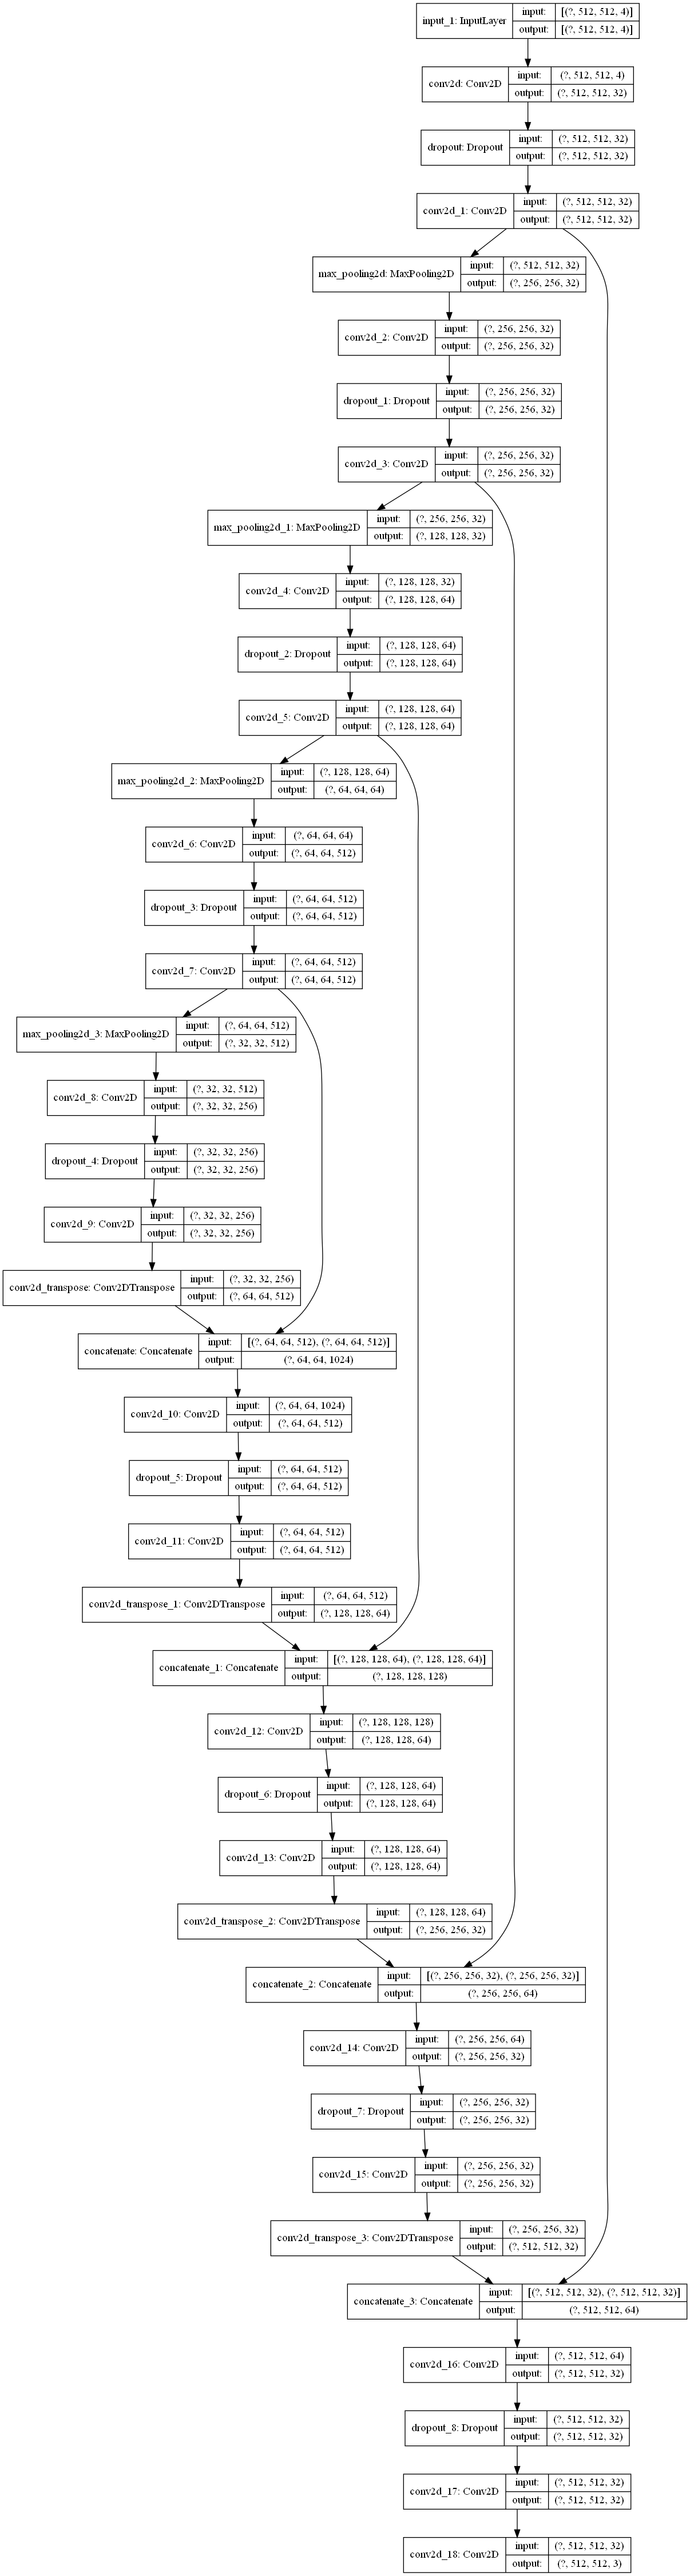

In [21]:
!pip install pydot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="D:/Geoprocessamento/DataSetModelo/u_net.png", show_shapes=True)

### Training

In [22]:
#training the model
model_history = model.fit(train_gen, 
                    epochs = 64, 
                    batch_size = BATCH_SIZE, 
                    validation_data = val_gen, 
                    callbacks = callbacks_list,
                    steps_per_epoch =(NO_OF_TRAINING_IMAGES/BATCH_SIZE), 
                    validation_steps = (NO_OF_VAL_IMAGES/BATCH_SIZE)
                  )

Epoch 1/64
90/89 [==============================] - ETA: -2s - loss: 0.4785 - accuracy: 0.6865 - f1: 0.6740
Epoch 00001: f1 improved from -inf to 0.67398, saving model to D:/Geoprocessamento/DataSetModelo\
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: D:/Geoprocessamento/DataSetModelo\assets
90/89 [==============================] - 975s 11s/step - loss: 0.4785 - accuracy: 0.6865 - f1: 0.6740 - val_loss: 0.3482 - val_accuracy: 0.7771 - val_f1: 0.7775
Epoch 2/64
90/89 [==============================] - ETA: -2s - loss: 0.3367 - accuracy: 0.7977 - f1: 0.7931
Epoch 00002: f1 improved from 0.67398 to 0.79309, saving model to D:/Geoprocessamento/DataSetModelo\
INFO:tensorflow:Assets written to: D:/Geoprocessamento/DataSetModelo\assets
90/89 [==============================]

90/89 [==============================] - ETA: -2s - loss: 0.3110 - accuracy: 0.8169 - f1: 0.8150
Epoch 00022: f1 did not improve from 0.83286
90/89 [==============================] - 895s 10s/step - loss: 0.3110 - accuracy: 0.8169 - f1: 0.8150 - val_loss: 0.3052 - val_accuracy: 0.8279 - val_f1: 0.8269
Epoch 23/64
90/89 [==============================] - ETA: -2s - loss: 0.2764 - accuracy: 0.8369 - f1: 0.8342
Epoch 00023: f1 improved from 0.83286 to 0.83424, saving model to D:/Geoprocessamento/DataSetModelo\
INFO:tensorflow:Assets written to: D:/Geoprocessamento/DataSetModelo\assets
90/89 [==============================] - 888s 10s/step - loss: 0.2764 - accuracy: 0.8369 - f1: 0.8342 - val_loss: 0.3122 - val_accuracy: 0.8005 - val_f1: 0.8011
Epoch 24/64
90/89 [==============================] - ETA: -2s - loss: 0.2869 - accuracy: 0.8320 - f1: 0.8300
Epoch 00024: f1 did not improve from 0.83424
90/89 [==============================] - 918s 10s/step - loss: 0.2869 - accuracy: 0.8320 - f1: 0

In [95]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

def get_test_batch(qnt_images):
    evaluate = []
    convert_to_image = keras.preprocessing.image.array_to_img
    dir_images = test_frame_path
    dir_masks = test_mask_path
    test_files = os.listdir(test_frame_path)
    #batch_images_structure
    mask_true_image_test = np.zeros((qnt_images,512,512,3))
    batch_test_images = np.zeros((qnt_images,512,512,len(BANDS)))

    for i in range(qnt_images):
        mask_test = np.load(dir_masks + test_files[i])
        mask_test = mask_test / 1
        mask_test = cv2.resize(mask_test, (512,512))
        
        imagem_teste = np.load(dir_images + test_files[i])[...,BANDS]
        imagem_teste = cv2.resize(imagem_teste, (512, 512))
        imagem_teste = cv2.resize(imagem_teste, (512, 512))
        
        x_eval = np.expand_dims(imagem_teste, axis=0)
        y_eval = np.expand_dims(mask_test, axis=0)
        
        evaluate.append(model.evaluate(x_eval,y_eval))
        
        
        mask_true_image_test [i,:,:] = mask_test
        batch_test_images [i,:,:] = imagem_teste
    return batch_test_images, mask_true_image_test, evaluate

In [96]:
qnt_images = 15
batch_test_images, mask_true_image_test, evaluate = get_test_batch(qnt_images)
mask_predict = model.predict(batch_test_images)

1/1 [==============================] - 0s 996us/step - loss: 0.3050 - accuracy: 1.0000 - f1: 0.9999


In [113]:
df_eval = pd.DataFrame(evaluate)
df_eval.columns = ["Loss", "Accuracy", "f1"]

In [121]:
df_eval.head(5)

Loss  Accuracy        f1
0  0.345849  0.823257  0.808452
1  0.246967  0.892170  0.883574
2  0.062982  1.000000  1.000000
3  0.131660  0.950466  0.949751
4  0.244452  1.000000  1.000000

In [122]:
print( 'Loss: ' + str(df_eval['Loss'].mean()))
print( 'F1: ' + str(df_eval['f1'].mean()))
print( 'Accuracy: ' + str(df_eval['Accuracy'].mean()))

Loss: 0.27430430352687835
F1: 0.7720993421971798
Accuracy: 0.8787101745605469


In [123]:
def show_images(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(512, 512, 4)


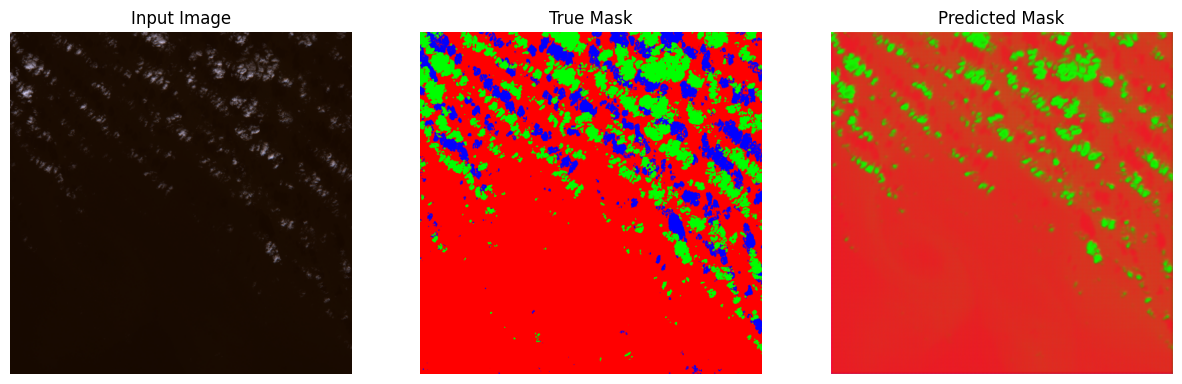

(512, 512, 4)


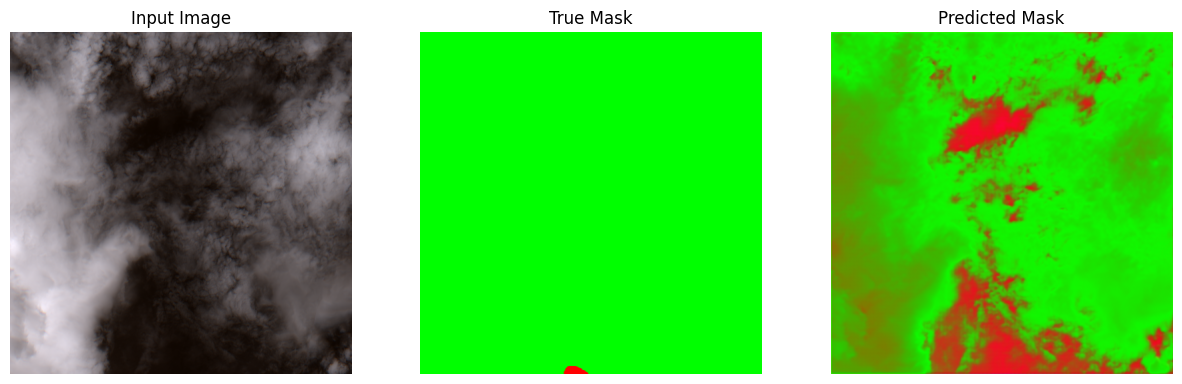

(512, 512, 4)


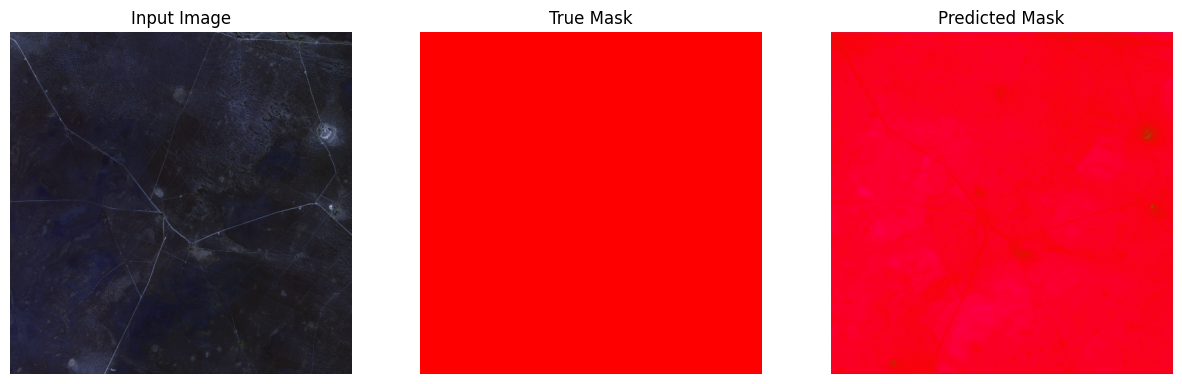

(512, 512, 4)


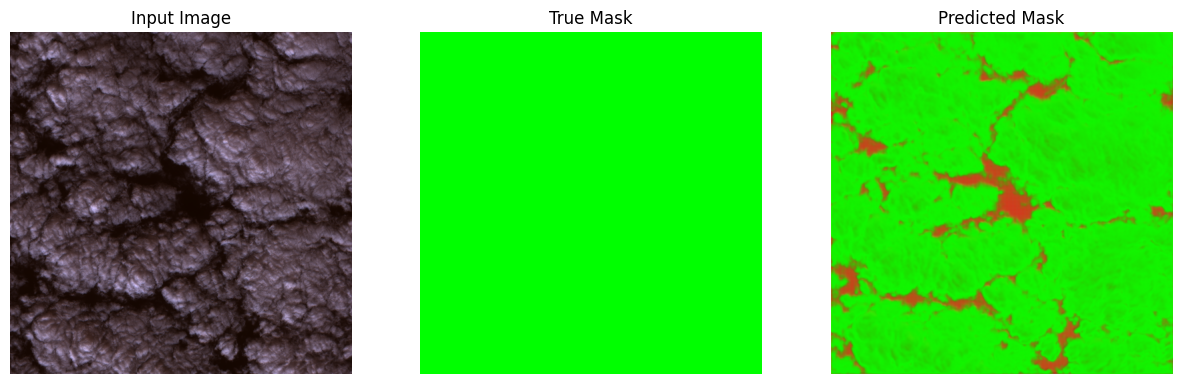

(512, 512, 4)


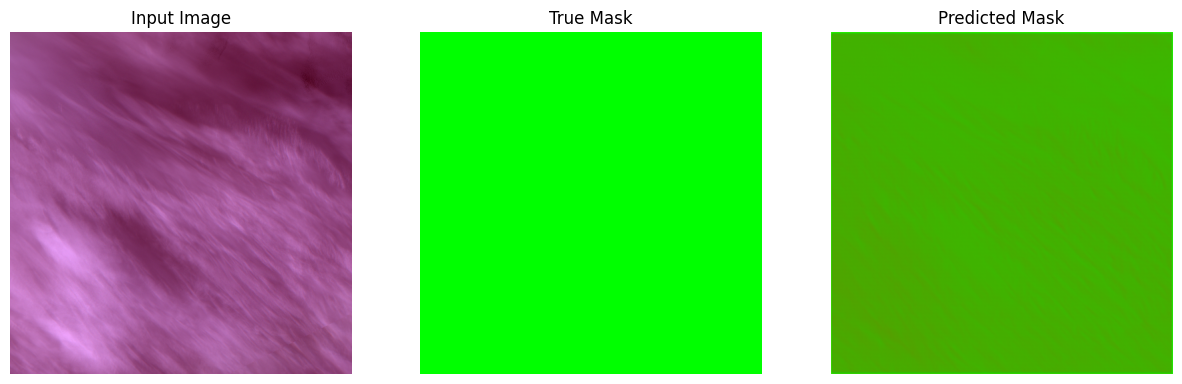

(512, 512, 4)


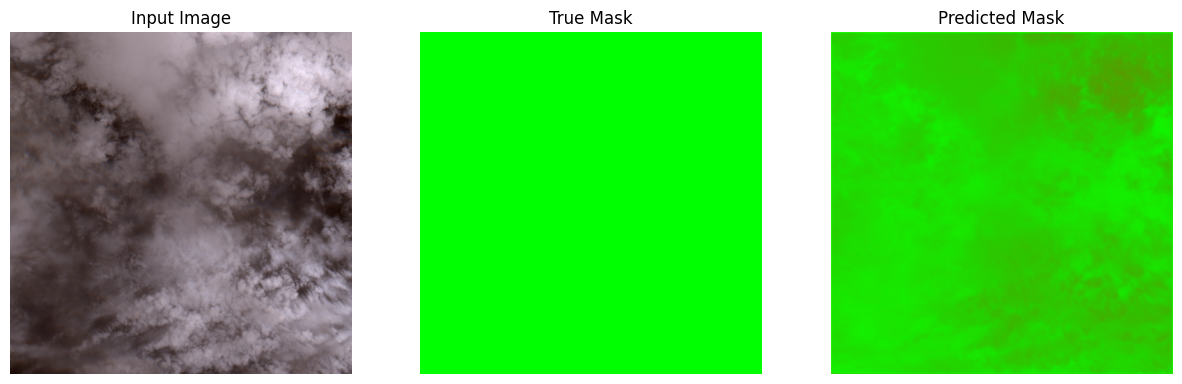

(512, 512, 4)


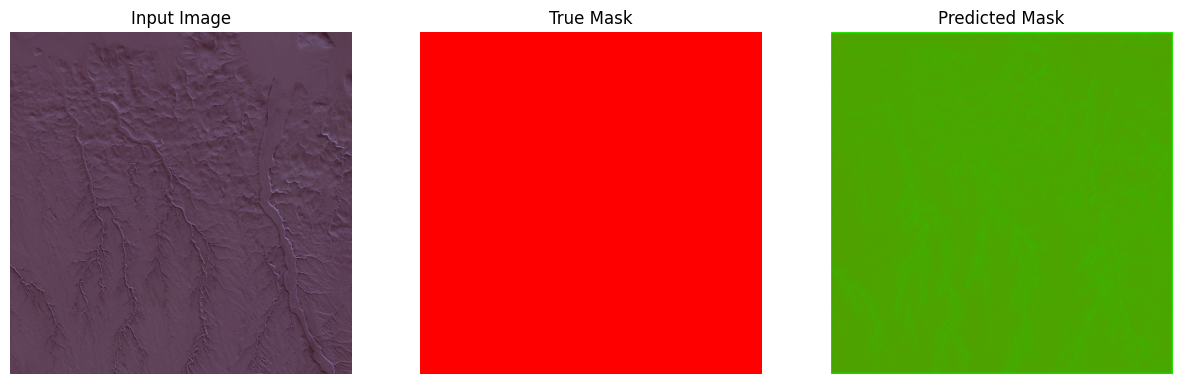

(512, 512, 4)


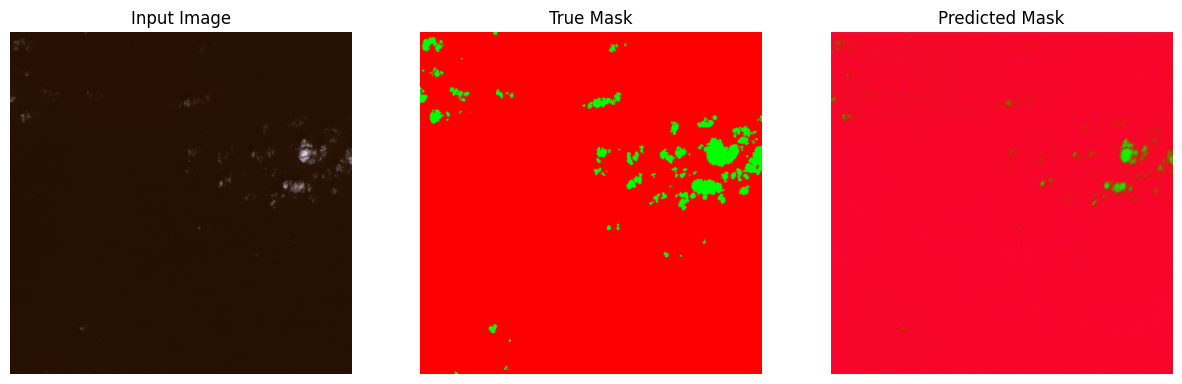

(512, 512, 4)


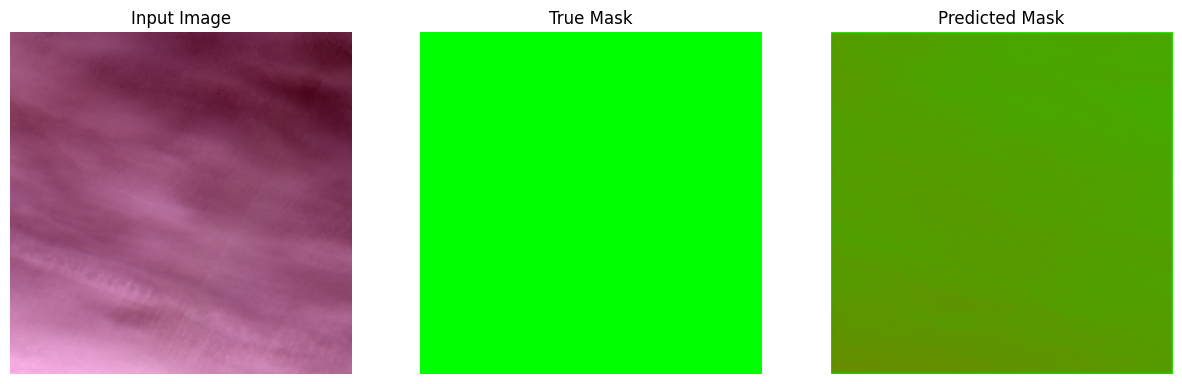

(512, 512, 4)


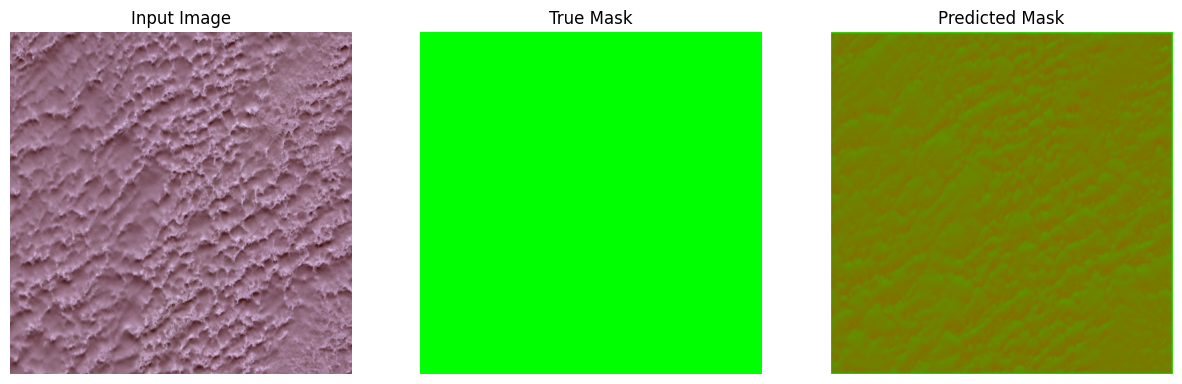

(512, 512, 4)


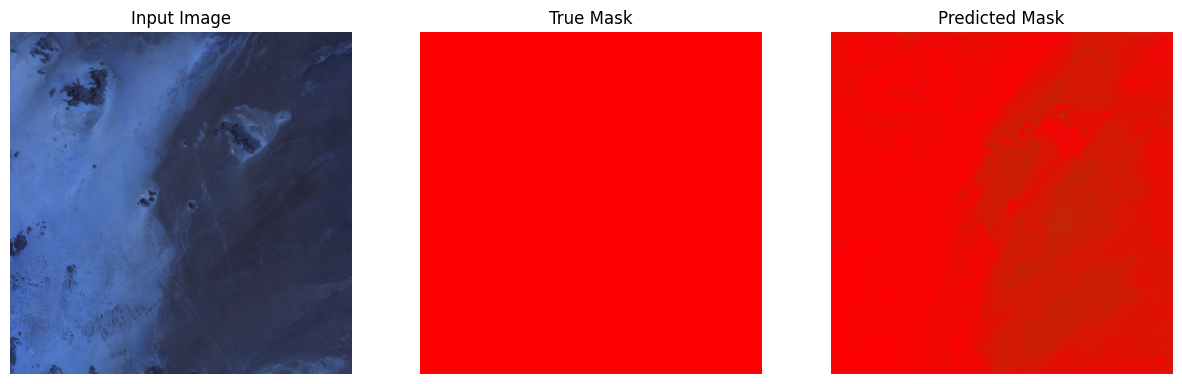

(512, 512, 4)


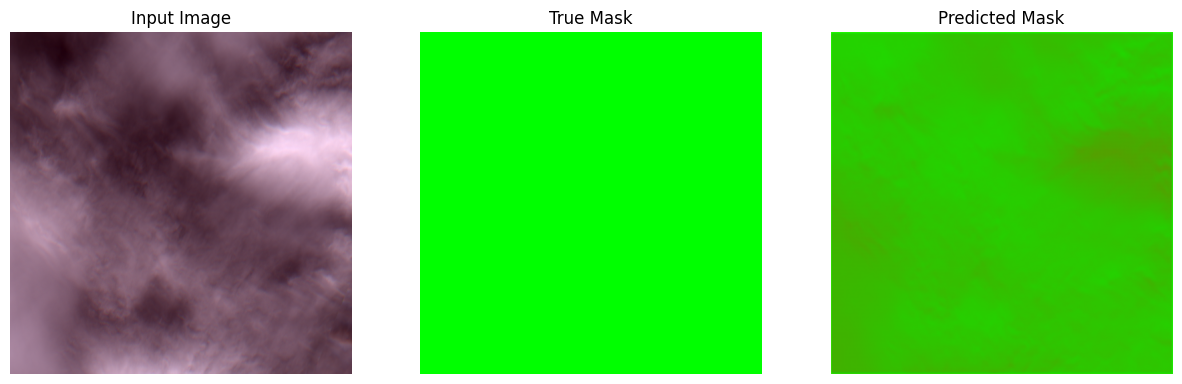

(512, 512, 4)


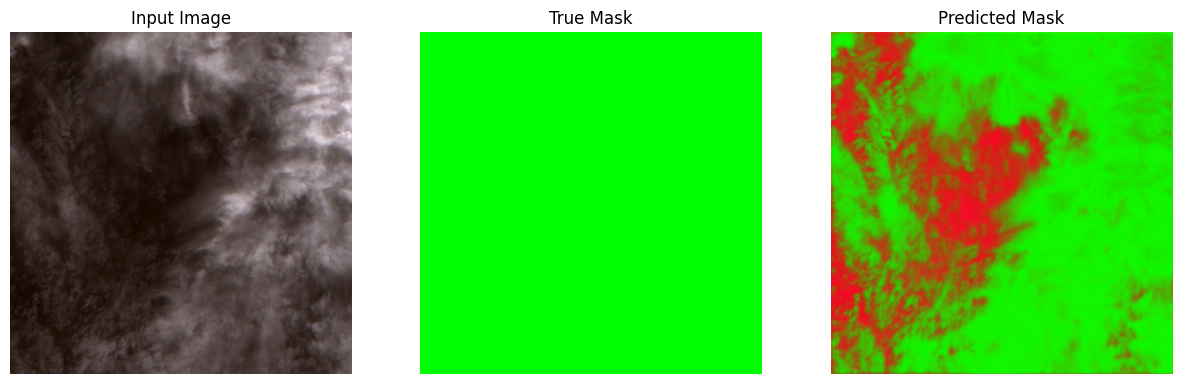

(512, 512, 4)


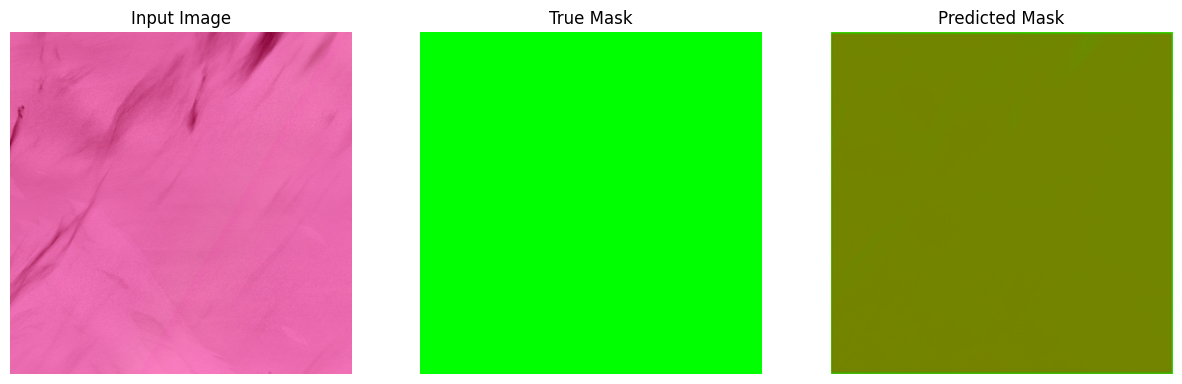

(512, 512, 4)


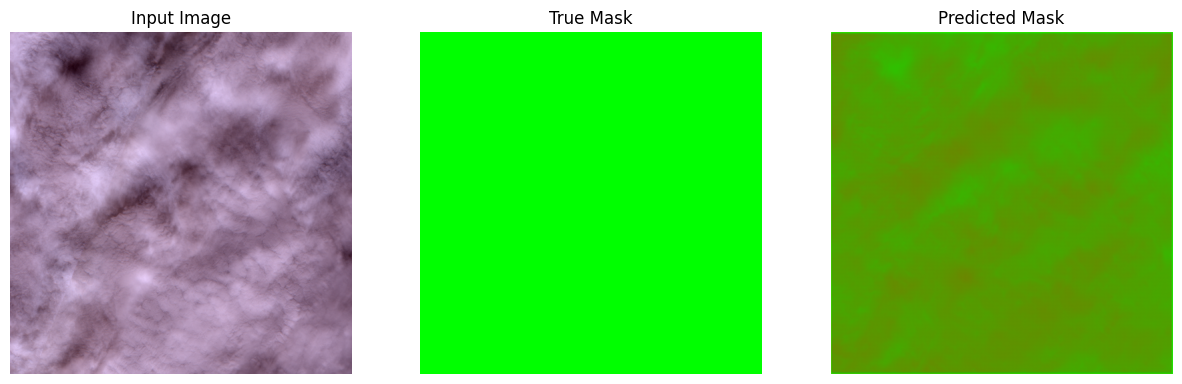

In [126]:
for i in range(qnt_images):
    print(batch_test_images[i].shape)
    show_images([batch_test_images[i][...,[3,2,1]], mask_true_image_test[i], mask_predict[i]])

# Test with l8_biome

In [28]:
from osgeo import gdal

In [29]:
def normalize_min_max(image):
    return((image-np.nanmin(image))/(np.nanmax(image)- np.nanmin(image)))

def resize_img(image,x,y,z):
    image = cv2.resize(image,(x,y))
    image = image.reshape((x,y,z))
    return image

def clip_image(r,g,b):
    return np.dstack((r,g,b))

def print_l8_biome_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

In [30]:
r = gdal.Open('D:/Geoprocessamento/DataSetModelo/l8_biome/BC/LC80200462014005LGN00/LC80200462014005LGN00_B3.TIF').ReadAsArray()
g = gdal.Open('D:/Geoprocessamento/DataSetModelo/l8_biome/BC/LC80200462014005LGN00/LC80200462014005LGN00_B2.TIF').ReadAsArray()
b = gdal.Open('D:/Geoprocessamento/DataSetModelo/l8_biome/BC/LC80200462014005LGN00/LC80200462014005LGN00_B1.TIF').ReadAsArray()
mask = gdal.Open('D:/Geoprocessamento/DataSetModelo/l8_biome/BC/LC80200462014005LGN00/LC80200462014005LGN00_fixedmask.img').ReadAsArray()

r = cv2.resize(r, (512, 512))# Read an image from folder and resize
r = r.reshape(512, 512, 1)
g = cv2.resize(g, (512, 512))# Read an image from folder and resize
g = g.reshape(512, 512, 1)
b = cv2.resize(b, (512, 512))# Read an image from folder and resize
b = b.reshape(512, 512, 1)
mask = cv2.resize(mask, (512, 512))
mask = mask.reshape(512, 512, 1)


r = normalize_min_max(r)
g = normalize_min_max(g)
b = normalize_min_max(b)
#mask = normalize_min_max(mask)

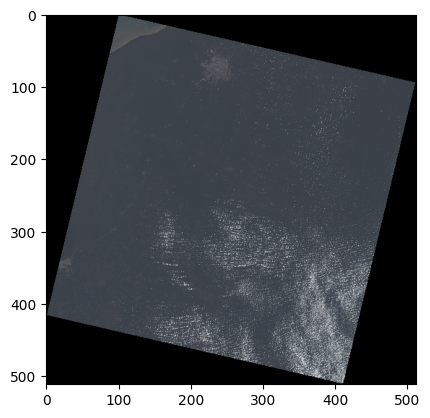

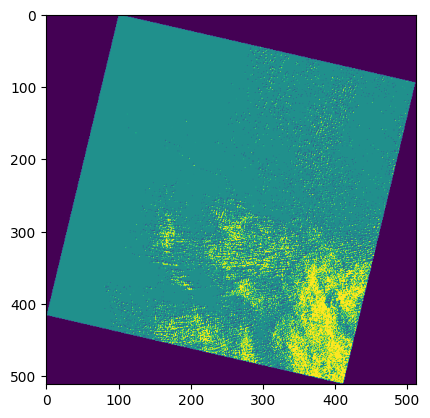

In [31]:
rgb = np.dstack((r,g,b))
plt.figure()
plt.imshow(rgb)
plt.show()
rgb = np.dstack((r,g,b))
plt.figure()
plt.imshow(mask)
plt.show()

In [43]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

def get_test_batch_l8_biome(qnt_images,dir_images, x,y,z):
    convert_to_image = keras.preprocessing.image.array_to_img
    dir_masks = test_mask_path
    folders = os.listdir(dir_images)
    
    #print(folders)

    #batch_images_structure
    mask_true_image_test = np.zeros((qnt_images,512,512,1))
    batch_test_images = np.zeros((qnt_images,512,512,len(BANDS)))
    for i in range(qnt_images):
        r = resize_img(normalize_min_max(gdal.Open(dir_images + '/' + str(folders[i]) + '/' + str(folders[i]) + '_B3.TIF').ReadAsArray()),x,y,z)
        g = resize_img(normalize_min_max(gdal.Open(dir_images + '/' + str(folders[i]) + '/' + str(folders[i]) + '_B2.TIF').ReadAsArray()),x,y,z)
        b = resize_img(normalize_min_max(gdal.Open(dir_images + '/' + str(folders[i]) + '/' + str(folders[i]) + '_B1.TIF').ReadAsArray()),x,y,z)
        
        mask = resize_img(normalize_min_max(gdal.Open(dir_images + '/' + str(folders[i]) + '/' + str(folders[i]) + '_B1.TIF').ReadAsArray()),x,y,z)
        rgb = clip_image(r,g,b)
        #print_l8_biome_image(mask)
        l8_x_eval = np.expand_dims(rgb, axis=0)
        l8_y_eval = np.expand_dims(mask, axis=0)
        
        model.evaluate(l8_x_eval,l8_y_eval)
        
        mask_true_image_test [i,:,:] = mask
        batch_test_images [i,:,:] = rgb
    return batch_test_images, mask_true_image_test

In [44]:
dir_images = 'D:/Geoprocessamento/DataSetModelo/l8_biome/BC/'
#shape da imagem
x,y,z = 512,512,1
l8_qnt_images = 17
l8_batch_test_images, l8_mask_true_image_test = get_test_batch_l8_biome(l8_qnt_images,dir_images, x,y,z)

InvalidArgumentError:  input depth must be evenly divisible by filter depth: 3 vs 4
	 [[node functional_1/conv2d/Elu (defined at <ipython-input-43-39b35305b1bf>:25) ]] [Op:__inference_test_function_82009]

Function call stack:
test_function


In [ ]:
l8_mask_predict = model.predict(batch_test_images)

In [42]:
for i in range(qnt_images):
    
    show_images([l8_batch_test_images[i], l8_mask_true_image_test[i], l8_mask_predict[i]])

NameError: name 'l8_batch_test_images' is not defined

# Aprendizado

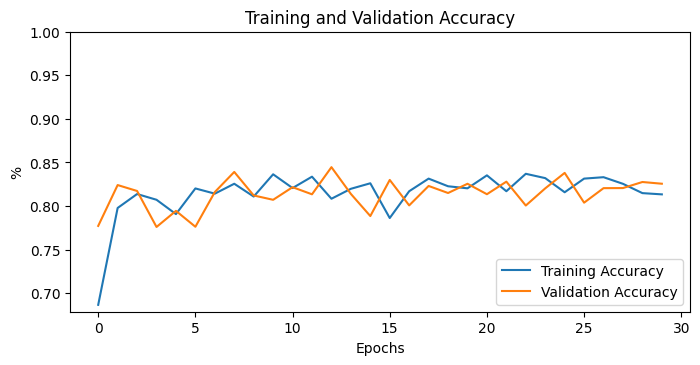

In [81]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('%')
plt.xlabel('Epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.savefig('accuracy.png')
plt.show()

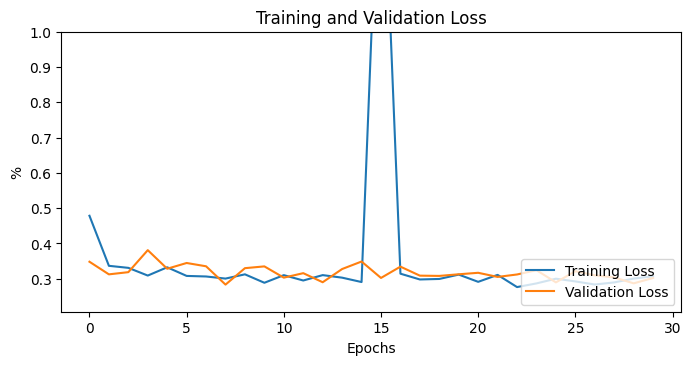

In [82]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='lower right')
plt.ylabel('%')
plt.xlabel('Epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')

plt.savefig('loss.png')
plt.show()

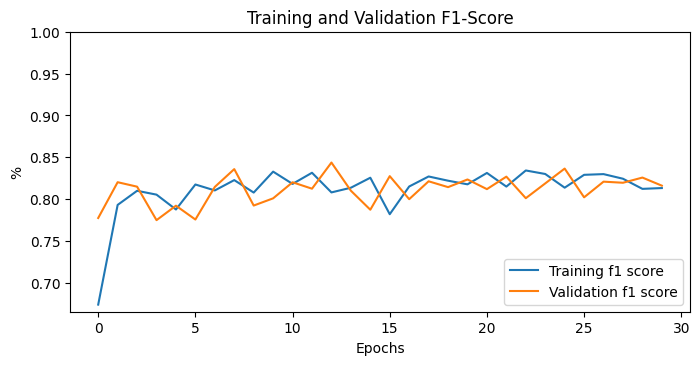

In [83]:


f1_score = model_history.history['f1']
val_f1_score = model_history.history['val_f1']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1_score, label='Training f1 score')
plt.plot(val_f1_score, label='Validation f1 score')

plt.legend(loc='lower right')
plt.ylabel('%')
plt.xlabel('Epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1-Score')
plt.savefig('f1.png')
plt.show()


In [ ]:
batch_test_images.shape
mask_predict.shape

In [ ]:
model.evaluate(x=batch_test_images,y=mask_predict)

In [ ]:
mask_predict.shape